In [13]:
from Color_functions import *
import numpy as np
import cv2
from skimage import io, color
import matplotlib.pyplot as plt
plt.gray()

<Figure size 640x480 with 0 Axes>

In [14]:
def threshold(D, cota_inferior=10):    # Basado en ecuación (12)
  return max(np.mean(D) + np.std(D), cota_inferior)

def computar_FD(L, L_prev):
  F = abs(L - L_prev)
  T_fd = threshold(F)
  return (F >= T_fd).astype('int8')

def computar_BD(L, BG_prev):
  B = abs(L - BG_prev)
  T_bd = threshold(B)
  return (B >= T_bd).astype('int8')

In [15]:
def actualizar_SI(fd, si_prev):
  return (fd == 0) * (si_prev + 1)

# T_si = cantidad de frames que el sistema puede procesar por segundo. En la función que procesa los videos, lo defino como los FPS del input
def actualizar_BG(L, BG_prev, SI, T_si):
  return np.where(SI == T_si, L, BG_prev)

In [16]:
def procesar_video(video_path):
  cap = cv2.VideoCapture(video_path)
  if not cap.isOpened():
      print("Error: Could not open video.")
      exit()

  fps_video = cap.get(cv2.CAP_PROP_FPS)

  # Leer el primer frame e inicializar las estructuras
  ret, frame_1 = cap.read()
  if not ret:
      print("Error: Could not read the first frame.")
      exit()
      
  L_1 = color.rgb2lab(frame_1[:,:,:3])[:,:,0]
  SI_1 = np.zeros(L_1.shape)
  BG_1 = np.zeros(L_1.shape)

  M_t = []    # Armo como una listita para los M que se van calculando. 
  while True:
      # Leer segundo frame
      ret, frame_2 = cap.read()
      if not ret:  # Salir si terminó el video
          break

      frame_2 = frame_2.astype(np.float32)/255
      frame_2_lab = color.rgb2lab(frame_2[:,:,:3])
      L_2 = frame_2_lab[:,:,0]

      # Calculo el FD y BD
      FD = computar_FD(L_2, L_1)
      BD = computar_BD(L_2, BG_1)

      M = FD | BD
      M_t.append(M)

      SI_2 = actualizar_SI(FD, SI_1)
      BG_2 = actualizar_BG(L_2, BG_1, SI_2, fps_video)

      if cv2.waitKey(30) & 0xFF == ord('q'):  # Press 'q' to quit
          break

      # Siguiente par de frames, actualizo frame2 para que sea el frame previo ahora.
      frame_1 = frame_2
      L_1 = L_2
      SI_1 = SI_2
      BG_1 = BG_2


  cap.release()
  cv2.destroyAllWindows()

  return M_t

In [17]:
M_t = procesar_video("imagenes/fire-ex.mp4")

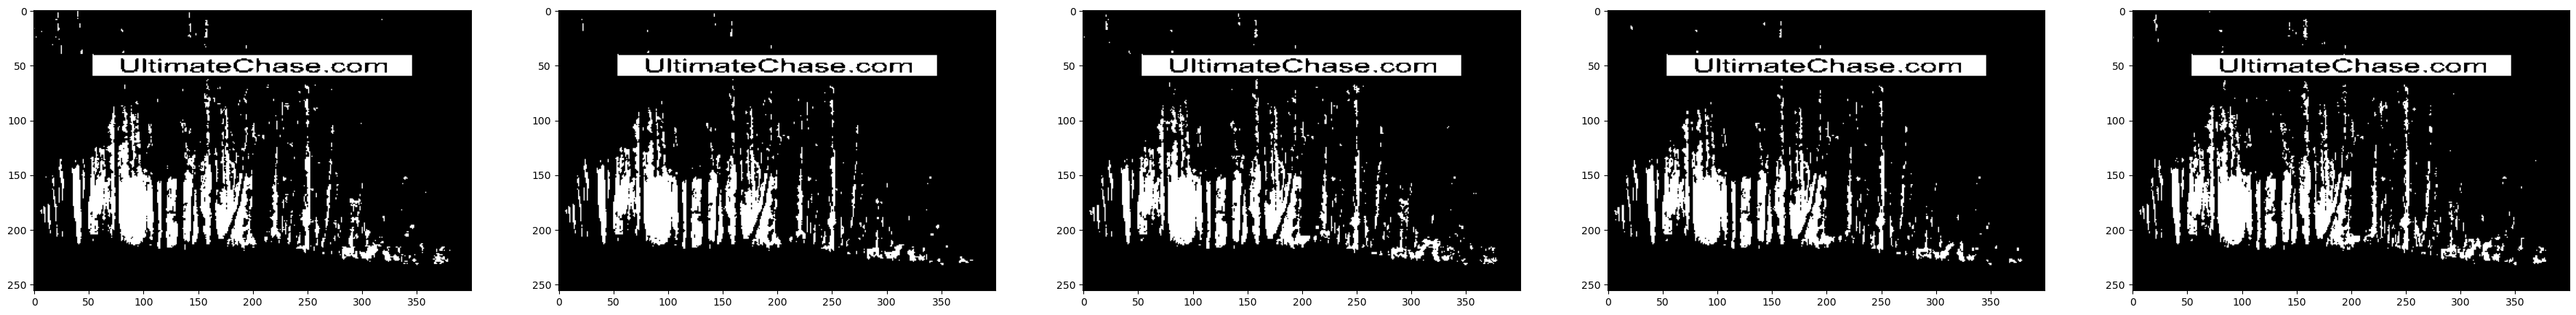

In [19]:
fig, axes = plt.subplots(1, 5, figsize=(45,65))

# Plotteo un par de ejemplos de la lista de M 
for i in range(5):
    axes[i].imshow(M_t[i])  

plt.show()